In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 5.7 MB/s eta 0:00:00


In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.0 MB/s eta 0:00:00


# Package Load

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

import re
import nltk
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import demoji

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#sklearn ML
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

#Transformers library for BERT
import tensorflow as tf
import transformers
from transformers import BertModel, TFRobertaModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification, TFBertForSequenceClassification, TFBertModel
from sklearn.metrics import classification_report, confusion_matrix
from transformers import InputExample, InputFeatures
from tqdm import tqdm
from tensorflow.keras.models import load_model

#Transformers library for RoBerta
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

import torch

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Raw Data Pre-processing

In [8]:
# opionion data
df_chi=pd.read_csv('/content/drive/MyDrive/yyx/5153_final_project/Opinion_Dataset/chi_concept_stock_opinion.csv').dropna()
df_expect_chi=pd.read_csv('/content/drive/MyDrive/yyx/5153_final_project/Opinion_Dataset/all_expect_chi.csv').dropna()

In [ ]:
# comment data, exclude amzn
folder_path = '/content/drive/MyDrive/yyx/5153_final_project/Comment_Dataset'

# Get a list of all CSV files in the folder
file_names = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Combine all CSV files into a single DataFrame
dfs = []
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path).dropna()
    dfs.append(df)
df_comment = pd.concat(dfs)

# randomly sample for comment data
index1=df_comment.sample(n=10000, random_state=42).index
df_comment_rest = df_comment.drop(index1)
index2=df_comment_rest.sample(n=2000, random_state=42).index
df_comment_unlabel = df_comment_rest.drop(index2)
df_comment_unlabel

In [ ]:
# comment amzn
amzn=pd.read_csv('/content/drive/MyDrive/yyx/5153_final_project/AMZN_Forums.csv')
amzn

index_amzn=amzn.sample(n=500, random_state=42).index
amzn=amzn.drop(index_amzn)
amzn

In [90]:
# all unlabeled
df_comment_unlabel=df_comment_unlabel.append(amzn)
df_comment_unlabel

<ipython-input-90-b891d48374b5>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comment_unlabel=df_comment_unlabel.append(amzn)


stock                 time  \
589   AAPL  Oct 08, 2022, 07:30   
751   AAPL  Sep 09, 2022, 03:02   
798   AAPL  Sep 02, 2022, 05:30   
816   AAPL  Aug 26, 2022, 02:00   
839   AAPL  Aug 20, 2022, 02:11   
...    ...                  ...   
2116  AMZN  Jan 01, 2022, 09:21   
2117  AMZN  Jan 01, 2022, 09:08   
2118  AMZN  Jan 01, 2022, 08:37   
2119  AMZN  Jan 01, 2022, 07:13   
2120  AMZN  Jan 01, 2022, 04:33   

                                                comment  
589                5 more points in 30 minutes possible  
751   LMFAO.  Government buying everything not naile...  
798               Google green. How apple still down 1%  
816           Thats one beatiful cup and handle forming  
839                                 time to buy the dip  
...                                                 ...  
2116                               no sl..add more 3340  
2117                                  long 3343 sl 3340  
2118          3 time in a row earning missing possible?  
2119             short at happy new year...shame on you  
2120                              show me the green lol  

[10665 rows x 3 columns]

In [91]:
# comment

def date_transform3(x):
    time_format = '%b %d, %Y'
    x=x[:len(x)-7]
    time_transform=datetime.strptime(x, time_format)
    time_transform2=time_transform.strftime("%Y-%m-%d")
    return time_transform2

df_comment_unlabel['time']=df_comment_unlabel['time'].apply(date_transform3)
df_comment_unlabel=df_comment_unlabel[['stock','time','comment']].drop_duplicates()
df_comment_unlabel

stock        time                                            comment
589   AAPL  2022-10-08               5 more points in 30 minutes possible
751   AAPL  2022-09-09  LMFAO.  Government buying everything not naile...
798   AAPL  2022-09-02              Google green. How apple still down 1%
816   AAPL  2022-08-26          Thats one beatiful cup and handle forming
839   AAPL  2022-08-20                                time to buy the dip
...    ...         ...                                                ...
2116  AMZN  2022-01-01                               no sl..add more 3340
2117  AMZN  2022-01-01                                  long 3343 sl 3340
2118  AMZN  2022-01-01          3 time in a row earning missing possible?
2119  AMZN  2022-01-01             short at happy new year...shame on you
2120  AMZN  2022-01-01                              show me the green lol

[10648 rows x 3 columns]

In [92]:
# save
df_comment_unlabel.to_csv('/content/drive/MyDrive/yyx/5153_final_project/df_comment_unlabel_final_0421.csv')

## Labeled Data Load

In [38]:
# amzn
df=pd.read_csv('/content/drive/MyDrive/yyx/5153_final_project/AMZN_label.csv')

import pandas as pd
from datetime import timedelta

def clean_time(time_str):
    # Check if the time_str contains '24:'
    if '24:' in time_str:
        # Replace '24:' with '00:'
        time_str = time_str.replace('24:', '00:')
        # Parse the datetime
        dt = pd.to_datetime(time_str, infer_datetime_format=True)
        # Add one day
        dt = dt + timedelta(days=1)
    else:
        dt = pd.to_datetime(time_str, infer_datetime_format=True)
        
    return dt


# Clean and convert the 'time' column to datetime format
df['time'] = df['time'].apply(clean_time)

# Format the 'time' column as a string with the desired format
df['time'] = df['time'].dt.strftime('%Y-%m-%d')
df=df.rename(columns={'stock':'stock','time':'date','comment':'text'})
df

stock        date                                               text  \
0    AMZN  2022-02-04                                     Thank you AMZN   
1    AMZN  2022-03-09  It is hanging in the air. Below 2500 there is ...   
2    AMZN  2022-11-12                                       would i buy?   
3    AMZN  2022-02-05  Still if you held this stock for the past year...   
4    AMZN  2022-02-04  must be a good report exactlyAmazon cost quite...   
..    ...         ...                                                ...   
495  AMZN  2022-02-11  Putting Rivian not profit capital to AMZN is a...   
496  AMZN  2022-07-08  We dont pay a subscription for SPAM. give them...   
497  AMZN  2022-02-02      no place to be in Amazon. sell it if you can.   
498  AMZN  2022-11-27                                  go to $180 please   
499  AMZN  2022-06-07                               Strong! As the same!   

     label  
0        1  
1        2  
2        0  
3        2  
4        1  
..     ...  
495      2  
496      2  
497      2  
498      1  
499      1  

[500 rows x 4 columns]

In [39]:
# label 6
df2=pd.read_csv('/content/drive/MyDrive/yyx/5153_final_project/label6.csv')

import pandas as pd
from datetime import timedelta

def clean_time(time_str):
    # Check if the time_str contains '24:'
    if '24:' in time_str:
        # Replace '24:' with '00:'
        time_str = time_str.replace('24:', '00:')
        # Parse the datetime
        dt = pd.to_datetime(time_str, infer_datetime_format=True)
        # Add one day
        dt = dt + timedelta(days=1)
    else:
        dt = pd.to_datetime(time_str, infer_datetime_format=True)
        
    return dt



# Clean and convert the 'time' column to datetime format
df2['time'] = df2['time'].apply(clean_time)

# Format the 'time' column as a string with the desired format
df2['time'] = df2['time'].dt.strftime('%Y-%m-%d')
df2=df2.rename(columns={'stock':'stock','time':'date','comment':'text'})
df2

stock        date                                               text  \
0     TSLA  2022-05-25  magically shreds all innocent money 💵 dear god...   
1      NIO  2022-01-25  Look people..all this blather trying to parse ...   
2     TSLA  2022-11-15  Elon MKL selling again 🤣 this MF should be ban...   
3     BABA  2022-03-15  Is it all about delisting fears that bring it ...   
4     TSLA  2022-08-10                                             brutal   
...    ...         ...                                                ...   
1995   NIO  2022-07-15  #TSLA Held 20 Day SMA today and closed above 7...   
1996  TSLA  2022-02-24                     750 as I wrote 10 hours ago...   
1997  TSLA  2022-11-10                           Crypto will push it down   
1998  TSLA  2022-03-04  This really doesnt want to move like the other...   
1999  TSLA  2022-04-25                                  Just can't sleep.   

      label  
0         2  
1         2  
2         2  
3         2  
4         2  
...     ...  
1995      1  
1996      1  
1997      2  
1998      0  
1999      0  

[2000 rows x 4 columns]

In [40]:
# comment data
folder_path = '/content/drive/MyDrive/yyx/5153_final_project/Comment_Label Dataset'

# Get a list of all CSV files in the folder
file_names = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Combine all CSV files into a single DataFrame
dfs = []
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    df_one = pd.read_csv(file_path, encoding='ISO-8859-1').dropna()
    dfs.append(df_one)
df_comment_label = pd.concat(dfs)

def date_transform4(x):
    try:
        time_format = '%Y/%m/%d'
        time_transform = datetime.strptime(x, time_format)
    except ValueError:
        time_format = '%d/%m/%Y'
        time_transform = datetime.strptime(x, time_format)
    
    time_transform2 = time_transform.strftime("%Y-%m-%d")
    return time_transform2


df_comment_label['time']=df_comment_label['time'].apply(date_transform4)
df_comment_label=df_comment_label[['stock','time','comment','label']].drop_duplicates()
df_comment_label=df_comment_label.rename(columns={'time':'date', 'comment':'text'})
df_comment_label

stock        date                                               text  \
0     AAPL  2023-02-03  Will be interesting to see when market opens n...   
1      NIO  2022-06-16                                                 hi   
2      NIO  2022-04-27                                   Will it see $13?   
3      AMD  2022-02-12                       You voted bearish  at 131.93   
4     TSLA  2022-10-21                                Almost -6.66% down    
...    ...         ...                                                ...   
1978   NIO  2022-03-10  Tomorrow morning NIO moves 60% of the float to...   
1979  META  2022-02-04                           PE 17 is historical dip    
1980  TSLA  2022-01-29  Who could have predicted this? Oh yea... &quot...   
1981  META  2022-02-09    Bears want this below 200 and they will buy :)    
1982  META  2022-10-22  I don't have meta stock I would not buy garbag...   

      label  
0       0.0  
1       0.0  
2       0.0  
3       2.0  
4       2.0  
...     ...  
1978    1.0  
1979    0.0  
1980    1.0  
1981    1.0  
1982    2.0  

[9948 rows x 4 columns]

In [42]:
# combine
df_comment_label=df_comment_label.append(df)
df_comment_label=df_comment_label.append(df2)

# save
df_comment_label.to_csv('/content/drive/MyDrive/yyx/5153_final_project/df_comment_label_final_0421_02.csv')

<ipython-input-42-0f6c97797d21>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comment_label=df_comment_label.append(df)
<ipython-input-42-0f6c97797d21>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comment_label=df_comment_label.append(df2)


# `Date` Transformation

In [9]:
# opinion

def date_transform1(x):
    time_format = '-\xa0%b %d, %Y'
    time_transform=datetime.strptime(x, time_format)
    time_transform2=time_transform.strftime("%Y-%m-%d")
    return time_transform2

def date_transform2(x):
    time_format = "\xa0-\xa0%b %d, %Y"
    time_transform=datetime.strptime(x, time_format)
    time_transform2=time_transform.strftime("%Y-%m-%d")
    return time_transform2

df_chi['Date']=pd.to_datetime(df_chi['Date'].apply(date_transform1))
df_chi=df_chi[['Stock','Date','Content']]

df_expect_chi['Date']=pd.to_datetime(df_expect_chi['Date'].apply(date_transform2))
df_expect_chi=df_expect_chi[['Stock','Date','Content']]

# combine
df_opinion=pd.concat([df_chi, df_expect_chi]).drop_duplicates()

In [21]:
# comment

def date_transform3(x):
    time_format = '%b %d, %Y'
    x=x[:len(x)-7]
    time_transform=datetime.strptime(x, time_format)
    time_transform2=time_transform.strftime("%Y-%m-%d")
    return time_transform2

df_comment['time']=df_comment['time'].apply(date_transform3)
df_comment=df_comment[['stock','time','comment']].drop_duplicates()

In [22]:
df_comment=df_comment.rename(columns={'stock':'stock','time':'date','comment':'text'})
df_comment['category']=1

df_opinion=df_opinion.rename(columns={'Stock':'stock','Date':'date','Content':'text'})
df_opinion['category']=2

In [ ]:
# # save whole comment & opinion
# df_comment.to_csv('/content/drive/MyDrive/yyx/5153_final_project/df_comment.csv', index=False)
# df_opinion.to_csv('/content/drive/MyDrive/yyx/5153_final_project/df_opinion.csv', index=False)

In [ ]:
# # randomly sample for comment data
# df_comment_sample=df_comment.sample(n=10000, random_state=42)
# df_comment_sample['label']=np.nan

# # Save
# tag=df_comment_sample.iloc[8000:10000]
# tag.to_csv('label5.csv', index=False)

In [ ]:
# # unlabeled comment dataset
# df_comment_rest = df_comment.drop(df_comment_sample.index)
# df_comment_rest.to_csv('/content/drive/MyDrive/yyx/5153_final_project/comment_unlabel.csv')

In [ ]:
# # randomly sample for opinion data
# df_opinion_sample=df_opinion.sample(n=1000, random_state=42)
# df_opinion_sample['label']=np.nan
# df_opinion_sample.to_csv('opinion_label.csv', index=False)

# Pre-processing

In [ ]:
def remove_stopwords(s, lang='english'): 
    #Custom stopwords
    new_words = ['already','also','comment','delete','even','haha','hahaha','hahahaha','literally',
                 'lolol','lololol','lolz','lols','lot','loll','lolololol','lolll',
                 'mean','na','point','post','probably','put','reddit','remove','see',
                 'something','want','well']
    stopwords = nltk.corpus.stopwords.words('english')  # list
    stopwords.extend(new_words)
    words = nltk.word_tokenize(s)
    removing_custom_words = [w for w in words if w.lower() not in stopwords]
    return " ".join(removing_custom_words)

def find_pos(word):
    # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    pos= nltk.pos_tag(nltk.word_tokenize(word))[0][1]
    if pos.lower()[0] == 'j':  ## Adjective tags -'JJ', 'JJR', 'JJS'
        return 'a'
    elif pos.lower()[0] == 'r':  ## Adverb tags -'RB', 'RBR', 'RBS'
        return 'r'
    elif pos.lower()[0] == 'v':  ## Verb tags -'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
        return 'v'
    else:  ## Noun tags -'NN', 'NNS', 'NNP', 'NNPS'
        return 'n'
    
def words_lemmatizer(s, encoding="utf8"):
    words = nltk.word_tokenize(s)
    lemma_words = []
    wl= WordNetLemmatizer()
    for word in words:
        pos= find_pos(word)
        lemma_words.append(wl.lemmatize(word, pos))
    return " ".join(lemma_words)

def remove_emoji(s):  
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Miscellaneous Symbols and Pictographs
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', s)

def text_preprocessing(s):
    s=s.lower()  ## Lowercasing
    s=s.replace('<[^>]+>', '')  ## Remove HTML tags
    s=s.replace('[^a-zA-Z0-9\s]', '')  ## Remove punctuation and special characters
    s=re.sub(r'\d+', '', s)  ## Remove numbers
    s=re.sub(r"\'t", " not", s) ## Change 't to 'not'
    s=re.sub(r'(@.*?)[\s]', ' ', s)  ## Remove @name
    s=re.sub(r'#\w+', '', s)  ## Remove #hastags
    s=re.sub(r'([\;\:\|•«\n])', ' ', s)  ## Remove some special characters
    s=re.sub(r'\s+', ' ', s).strip()  ## Remove trailing whitespace
    s=re.sub(r'[^a-zA-Z0-9_#@&\s]', ' ', s)  ## Removes all characters from the string except for alphabets (both upper and lower case), digits, underscore, hash symbol, ampersand symbol and whitespace characters.
    s=re.sub(r'&[\w]+', ' ', s)  ## Removes all words starting with an ampersand symbol from the string.

    s=words_lemmatizer(s)  ## Lemmatization
    s=remove_stopwords(s)  ## Remove stopwords
    return s

# Sentiment Prediction - Comment & Opinion

## Data Load

In [5]:
# opinion
df_opinion_label=pd.read_csv('/content/drive/MyDrive/yyx/5153_final_project/df_opinion_label_final_0422.csv', index_col=0)
df_opinion_unlabel=pd.read_csv('/content/drive/MyDrive/yyx/5153_final_project/df_opinion_unlabel_final_0422.csv', index_col=0)

In [6]:
# comment
df_comment_unlabel=pd.read_csv('/content/drive/MyDrive/yyx/5153_final_project/df_comment_unlabel_final_0421.csv', index_col=0)
df_comment_label=pd.read_csv('/content/drive/MyDrive/yyx/5153_final_project/df_comment_label_final_0421.csv', index_col=0)

# pre-processing
df_comment_label['category']=1
df_comment_label=df_comment_label[['stock','date','text','category','label']]

df_comment_unlabel=df_comment_unlabel.rename(columns={'time':'date','comment':'text'})
df_comment_unlabel['category']=1

In [7]:
# combine
df_label=pd.concat([df_opinion_label, df_comment_label], axis=0)
df_unlabel=pd.concat([df_opinion_unlabel, df_comment_unlabel], axis=0)

## Model 1. TF-IDF & NB

In [9]:
# create input data
X = df_label['text'].values
y = df_label['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=123)

In [10]:
# tokenize the text using CountVectorizer
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_val_cv = clf.transform(X_val)

# create the TF-IDF (term-frequency times inverse document-frequency) versions of the tokenized text
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_val_tf = tf_transformer.transform(X_val_cv)

In [11]:
# define NB model
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train)

# prediction
nb_pred = nb_clf.predict(X_val_tf)

# evaluation
accuracy = accuracy_score(y_val, nb_pred)
print('Accuracy:', accuracy)

Accuracy: 0.5915057915057915


## Model 2. BERT Embedding + LR

In [27]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
embedding_model = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
# Step 1: Tokenization
max_len = 512
tokenized = df_label['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_len, truncation=True)))

# Step 2: Padding
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
print(padded.shape)

# Step 3: Masking
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

# Step 4: Pre-trained BERT Model
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

feature_list = []
with torch.no_grad():
    for batch_idx in range(0, padded.shape[0], 10):
        # BERT check 10 sample each time.
        input_ids = torch.tensor(padded[batch_idx:batch_idx+10])
        used_attention_mask = torch.tensor(attention_mask[batch_idx:batch_idx+10])
        last_hidden_states = embedding_model(input_ids, attention_mask=used_attention_mask)
        # Get the embeddings for the [CLS] tag (position is 0)
        features = last_hidden_states[0][:, 0, :].numpy()
        feature_list.append(features)

# preprare features
features = np.vstack(feature_list)
features.shape

(12948, 512)


<ipython-input-28-0c9f2fe9bc7c>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  used_attention_mask = torch.tensor(attention_mask[batch_idx:batch_idx+10])


(12948, 768)

In [29]:
# Save features to a file
np.save('/content/drive/MyDrive/yyx/5153_final_project/all_features_BERT_0423.npy', features)

# # # Load features
# features = np.load("/content/drive/MyDrive/yyx/features.npy")
# features_test = np.load("/content/drive/MyDrive/yyx/features_test.npy")

### LR

In [30]:
#get BERT embedding
labels = df_label.label.tolist()
train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=0.1, random_state=123)

In [31]:
lr_clf = LogisticRegression(max_iter=20000)
lr_clf.fit(train_features, train_labels)

#validate the model
lr_accuracy = lr_clf.score(val_features, val_labels)
print('Accuracy of LR model on validation data: {:.2f}%'.format(lr_accuracy*100))

Accuracy of LR model on validation data: 57.07%


### RF

In [32]:
rf_clf = RandomForestClassifier(
    n_estimators = 100, # number of trees, 不需要tune
    max_depth= 10,       # parameters for the individual trees
    random_state = 22   # random state for reproducibility
)

rf_clf.fit(train_features, train_labels)

# Evaluate the Random Forest model
rf_pred_labels = rf_clf.predict(val_features)
rf_accuracy = accuracy_score(val_labels, rf_pred_labels)
print('Accuracy of RF model on validation data: {:.2f}%'.format(rf_accuracy*100))

Accuracy of RF model on validation data: 56.53%


### SVM

In [33]:
# Create an SVM object
svm_clf = SVC(kernel='rbf')

# Train the SVM model on the training features and labels
svm_clf.fit(train_features, train_labels)

# Predict the labels of validation data
val_pred_labels = svm_clf.predict(val_features)
svm_accuracy = accuracy_score(val_labels, val_pred_labels)
print('Accuracy of SVM model on validation data: {:.2f}%'.format(svm_accuracy*100))

Accuracy of SVM model on validation data: 59.85%


## Model 3. BERT

In [21]:
# get data
X = df_label['text'].values
y = df_label['label'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=123)
# X_test=df_test['Text'].values

# one-hot encoder
y_train_le = y_train.copy()
y_val_le = y_val.copy()

ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = ohe.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()

# print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_val.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

In [22]:
MAX_LEN=512

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True,
            truncation=True  # Ensure tokens are truncated to max_len
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.vstack(input_ids), np.vstack(attention_masks)

train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_val, MAX_LEN)
# test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [23]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def create_model(bert_model, max_len=MAX_LEN):
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    embeddings = bert_model([input_ids,attention_masks])[1]
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)

    return model

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [24]:
model_bert = create_model(bert_model, MAX_LEN)
model_bert.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

In [25]:
# fine tune
history_bert = model_bert.fit([train_input_ids, train_attention_masks], y_train, 
                         validation_data=([val_input_ids,val_attention_masks], y_val), 
                         epochs=5, 
                         batch_size=32)

Epoch 1/5
365/365 [==============================] - 223s 491ms/step - loss: 0.8961 - categorical_accuracy: 0.5879 - val_loss: 0.7470 - val_categorical_accuracy: 0.6718
Epoch 2/5
365/365 [==============================] - 168s 460ms/step - loss: 0.7032 - categorical_accuracy: 0.7078 - val_loss: 0.7199 - val_categorical_accuracy: 0.6988
Epoch 3/5
365/365 [==============================] - 165s 452ms/step - loss: 0.5880 - categorical_accuracy: 0.7664 - val_loss: 0.7239 - val_categorical_accuracy: 0.6996
Epoch 4/5
365/365 [==============================] - 163s 447ms/step - loss: 0.4544 - categorical_accuracy: 0.8282 - val_loss: 0.8236 - val_categorical_accuracy: 0.6880
Epoch 5/5
365/365 [==============================] - 162s 443ms/step - loss: 0.3458 - categorical_accuracy: 0.8727 - val_loss: 0.9180 - val_categorical_accuracy: 0.6687


## Model 4. RoBERTa

### Fit

In [8]:
# import the tokenizer used to train the original roberta transformer
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

# import roberta
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [9]:
# get data
# create input data
X = df_label['text'].values
y = df_label['label'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=123)

# one-hot encoder
y_train_le = y_train.copy()
y_val_le = y_val.copy()

ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = ohe.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()

print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_val.shape[0]}" )
# print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_val.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 11653
VALIDATION DATA: 1295


In [10]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)

# tokenize
MAX_LEN=512

def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            truncation=True  # Ensure tokens are truncated to max_len
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.vstack(input_ids), np.vstack(attention_masks)

train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_val, MAX_LEN)
# test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [11]:
def create_model(bert_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

all_roberta = create_model(roberta_model, MAX_LEN)
all_roberta.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [12]:
# 1
all_roberta_history1 = all_roberta.fit([train_input_ids,train_attention_masks], y_train, 
                                      validation_data=([val_input_ids,val_attention_masks], y_val), 
                                      epochs=3, 
                                      batch_size=30)

Epoch 1/3
389/389 [==============================] - 249s 521ms/step - loss: 0.8430 - categorical_accuracy: 0.6159 - val_loss: 0.7070 - val_categorical_accuracy: 0.6996
Epoch 2/3
389/389 [==============================] - 176s 454ms/step - loss: 0.6655 - categorical_accuracy: 0.7288 - val_loss: 0.6669 - val_categorical_accuracy: 0.7089
Epoch 3/3
389/389 [==============================] - 168s 433ms/step - loss: 0.5760 - categorical_accuracy: 0.7679 - val_loss: 0.7188 - val_categorical_accuracy: 0.6981


In [6]:
# # Save the trained model
# all_roberta_history1.model.save("/content/drive/MyDrive/yyx/5153_final_project/all_roberta_0422.h5")

# # load
# # Define custom objects dictionary
# custom_objects = {'TFRobertaModel': TFRobertaModel}

# # Load the saved model with custom objects
# load_roberta = load_model('/content/drive/MyDrive/yyx/5153_final_project/all_roberta_0422.h5', custom_objects=custom_objects)

# # # Print the model summary
# # load.summary()

In [13]:
# predict validation
result_roberta = load_roberta.predict([val_input_ids,val_attention_masks])

y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

result=y_pred_roberta.argmax(1)

41/41 [==============================] - 9s 145ms/step


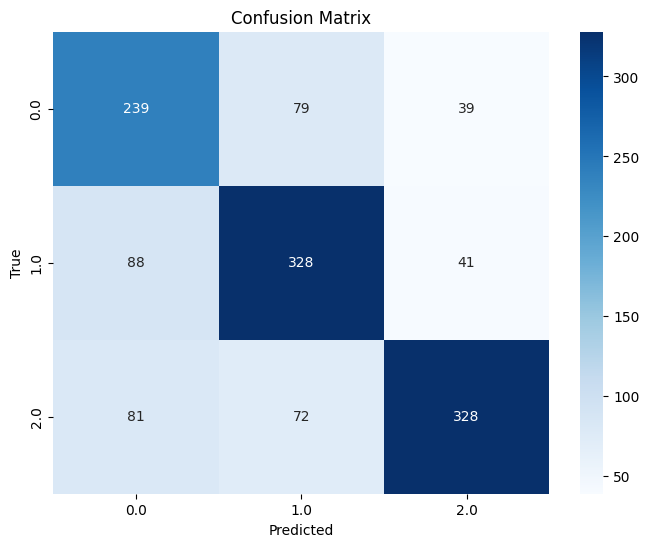

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert one-hot encoded true labels and predicted labels back to original form
y_val_original = np.argmax(y_val, axis=1)
y_pred_original = np.argmax(y_pred_roberta, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_val_original, y_pred_original)

# Define a function to plot the fancy confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# List the class names in the order they were encoded (e.g., ["negative", "neutral", "positive"])
class_names = ohe.categories_[0]

# Plot the fancy confusion matrix
plot_confusion_matrix(cm, class_names)


In [19]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val_original, y_pred_original)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[239  79  39]
 [ 88 328  41]
 [ 81  72 328]]


### Predict

In [16]:
X_test=df_unlabel['text'].values
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [17]:
# predict
result_roberta = load.predict([test_input_ids,test_attention_masks])

y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

result=y_pred_roberta.argmax(1)

413/413 [==============================] - 63s 146ms/step


In [18]:
df_result = df_unlabel.reset_index(drop=True)
df_result['label'] = result
df_result

stock        date                                               text  \
0      BABA  2023-01-31  China's reopening has revived its economy but ...   
1      BABA  2023-01-26  Investors seem to be positioning for a strong ...   
2      BABA  2023-01-17  E-commerce behemoth Alibaba Group Holdings (NY...   
3      BABA  2023-01-13  Alibaba shares are up 100% from their lows. Ta...   
4      BABA  2023-01-13  The continued easing of US price pressures has...   
...     ...         ...                                                ...   
13188  AMZN  2022-01-01                               no sl..add more 3340   
13189  AMZN  2022-01-01                                  long 3343 sl 3340   
13190  AMZN  2022-01-01          3 time in a row earning missing possible?   
13191  AMZN  2022-01-01             short at happy new year...shame on you   
13192  AMZN  2022-01-01                              show me the green lol   

       category  label  
0             2      1  
1             2      1  
2             2      1  
3             2      1  
4             2      0  
...         ...    ...  
13188         1      1  
13189         1      1  
13190         1      0  
13191         1      2  
13192         1      1  

[13193 rows x 5 columns]

In [19]:
df_all=pd.concat([df_result, df_label], axis=0)
df_all.to_csv('/content/drive/MyDrive/yyx/5153_final_project/Sentiment_Prediction_Dataset/df_all_predict_0422.csv', index=False)